# 1: Librerie
Importazione di tutte le librerie necessarie per la gestione del dataset, la costruzione del modello e l'apprendimento della rete.

* `tensorflow`: Funzioni di creazione del modello, e di gestione della fase di training.
* `numpy`: Gestione di array e funzioni di calcolo.
* `pandas`: Funzioni di apertura e parsing del dataset.
* `matplotlib`: Funzioni di gestione dei grafici, per la visualizzazione dei risultati in fase di training.

In [57]:
"""
Install dependencies:
>>> pip install --update pip
>>> pip install numpy pandas matplotlib seaborn scikit-learn
"""

'\nInstall dependencies:\n>>> pip install --update pip\n>>> pip install numpy pandas matplotlib seaborn scikit-learn\n'

In [58]:
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers     as layers
import tensorflow.keras.models     as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks            import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import LabelEncoder as le

## Variabili globali
* `num_layers`: Configurazione degli strati della rete. Aggiungendo e rimuovendo neuroni, è possibile modificare la rete.
    * Ogni elemento di `num_layers` dovrebbe essere un array di 3 elementi: numero di neuroni nello strato, funzione di attivazione, larghezza del dropout.
* `num_epochs`: Numero di epoche di training del modello.
* `batch_size`: Larghezza dei batch durante la fase di training.

In [59]:
net_layers = [
    [32, 'relu', 0.2] for _ in range(2)] + [
    [64, 'relu', 0.2] for _ in range(3)] + [
    [32, 'relu', 0.5] for _ in range(2)
]
num_epochs = 75 # Number of epochs
batch_size = 16 # Batch size

# 2: Dataset augmentation function


In [60]:
def dataset_augmentation(dataset: pd.DataFrame, target_count = 1000, column_augmentation = ['Age', 'Old']) -> pd.DataFrame:

    col_key     = column_augmentation[0] # key column for filtering
    col_val     = column_augmentation[1] # value to filter by
    old_samples = dataset[dataset[col_key] == col_val].copy() # filter samples
    
    # check if there are any samples to augment
    if len(old_samples) == 0:
        print(f"WARNING: No samples found for {col_val} in column {col_key} for data augmentation.")
        return dataset
    
    # check if the number of samples is already sufficient
    if len(old_samples) >= target_count:
        print(f"WARNING: Number of samples for {col_val} in column {col_key} is already sufficient.")
        return dataset
    
    print(f"Target number of values for {col_val}: {target_count}")
    print(f"Number of samples found: {len(old_samples)}")

    num_cols = old_samples.keys()[1 : -1] # skip first and last column (not numeric features)
    
    synthetic_samples = []
    samples_needed    = target_count - len(old_samples)
    
    for i in range(samples_needed):

        base_sample = old_samples.sample(n = 1).iloc[0].copy() # base sample from 'Old' samples
        
        for col in num_cols: # add noise to numeric columns
            noise_factor     = np.random.uniform(0.02, 0.08)
            noise            = np.random.normal(0, base_sample[col] * noise_factor)
            base_sample[col] = max(0, base_sample[col] + noise) # ensure no negative values
        
        synthetic_samples.append(base_sample) # append modified sample to list
    
    # convert list of synthetic samples to DataFrame
    synthetic_df      = pd.DataFrame(synthetic_samples)
    augmented_dataset = pd.concat([dataset, synthetic_df], ignore_index = True)
    
    print(f"Number of samples after augmentation: {len(augmented_dataset)}")
    
    return augmented_dataset # return augmented dataset with synthetic samples

# 3: Dataset
Importazione del dataset e divisione delle istanze per validation, training e testing.

## Obiettivo del modello
Classificazione dell'età di un *abalone*, a seconda delle misure fisiche effettuate.

* Elementi: **4177** istanze
* Features disponibili: **8** colonne
* Classificazione: **3** classi

In [61]:
try:

  dataset = pd.read_csv("./Dataset.csv") # load the dataset

  dataset['Sex'] = le().fit_transform(dataset['Sex']) # label encoding for column 'Sex'
  
  for val in dataset['Age'].unique(): # Dataset augmentation
    dataset = dataset_augmentation(dataset, target_count = 1500, column_augmentation = ['Age', val]) 

  # One-hot encoding for column 'Age'
  column     = 'Age'
  dataset    = pd.get_dummies(dataset, columns = [column], prefix = column)
  dummy_cols = [col for col in dataset.columns if col.startswith(f'{column}_')]

  # Separate features and labels
  Y = dataset[dummy_cols]
  X = dataset.drop(columns = dummy_cols)

  # First split: 70% train, 30% combined validation and test
  X_train, X_combined, Y_train, Y_combined = train_test_split(
    X, Y, test_size = 0.3, random_state = 42)

  # Second split: 50% validation, 50% test from the 30% combined set
  X_val, X_test, Y_val, Y_test = train_test_split(
    X_combined, Y_combined, test_size = 0.5, random_state = 42)

  print("\nTraining set shape:  ", X_train.shape, Y_train.shape)
  print("Validation set shape:", X_val.shape, Y_val.shape)
  print("Test set shape:      ", X_test.shape, Y_test.shape)
except FileNotFoundError:
  print("ERROR: Dataset file not found. Please ensure the file 'Dataset.csv' is in the current directory.")

Target number of values for Old: 1500
Number of samples found: 36
Number of samples after augmentation: 5641

Training set shape:   (3948, 8) (3948, 3)
Validation set shape: (846, 8) (846, 3)
Test set shape:       (847, 8) (847, 3)


# 4: Creazione del modello
Generazione di un modello di rete neurale.

In [62]:
model = models.Sequential([layers.Input(shape = (X_train.shape[1],))]) # Input layer

for layer in net_layers: # Add hidden layers
    model.add(layers.Dense(layer[0], activation = layer[1])) # Dense layer
    model.add(layers.Dropout(layer[2])) # Dropout layer to prevent overfitting
    model.add(layers.BatchNormalization()) # Batch normalization layer
    
model.add(layers.Dense(Y_train.shape[1], activation = 'softmax')) # Output layer

model.summary() # Print the model summary

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 16,291 (63.64 KB)

 Trainable params: 15,651 (61.14 KB)

 Non-trainable params: 640 (2.50 KB)

## 5: Compilazione e training del modello generato

In [65]:
lr_schedule = ExponentialDecay(
    initial_learning_rate = 1e-4, # Starting learning rate
    decay_steps           = 20e3, # Number of steps before decay
    decay_rate            = 0.96, # Multiplicative decay factor
)

model.compile(
    optimizer = optimizers.Adam(learning_rate = lr_schedule),
    loss      = 'categorical_crossentropy', 
    metrics   = ['accuracy', 'Precision', 'Recall']
)

# early_stop = EarlyStopping(
#     monitor              = 'val_loss',
#     patience             = 10,
#     restore_best_weights = True
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor  = 'val_loss',
#     factor   = 0.5,
#     patience = 5,
#     min_lr   = 0.0001,
#     verbose  = 1
# )

history = model.fit(
    X_train, Y_train,
    epochs          = num_epochs,    # Number of epochs
    batch_size      = batch_size,    # Batch size
    validation_data = (X_val, Y_val)
)

Epoch 1/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - Precision: 0.6684 - Recall: 0.5363 - accuracy: 0.6430 - loss: 0.7865 - val_Precision: 0.8007 - val_Recall: 0.5272 - val_accuracy: 0.6915 - val_loss: 0.6990
Epoch 2/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - Precision: 0.6807 - Recall: 0.5486 - accuracy: 0.6421 - loss: 0.7732 - val_Precision: 0.8011 - val_Recall: 0.5047 - val_accuracy: 0.7069 - val_loss: 0.7006
Epoch 3/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - Precision: 0.6956 - Recall: 0.5396 - accuracy: 0.6588 - loss: 0.7482 - val_Precision: 0.8044 - val_Recall: 0.5201 - val_accuracy: 0.6891 - val_loss: 0.7073
Epoch 4/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Precision: 0.7075 - Recall: 0.5567 - accuracy: 0.6694 - loss: 0.7441 - val_Precision: 0.8026 - val_Recall: 0.5095 - val_accuracy: 0.6939 - val_loss: 0.7049
Epoch 5/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - Precision: 0.7062 - Recall: 0.5588 - accuracy: 0.6657 - loss: 0.7515 - val_Precision: 0.8007 - val_R

## 6: Visualizzazione dei risultati

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.8029 - Recall: 0.5105 - accuracy: 0.7050 - loss: 0.7123
Test set evaluation:
Precision: 0.7913
Recall:    0.4923
Loss:      0.7264
Accuracy:  0.6919


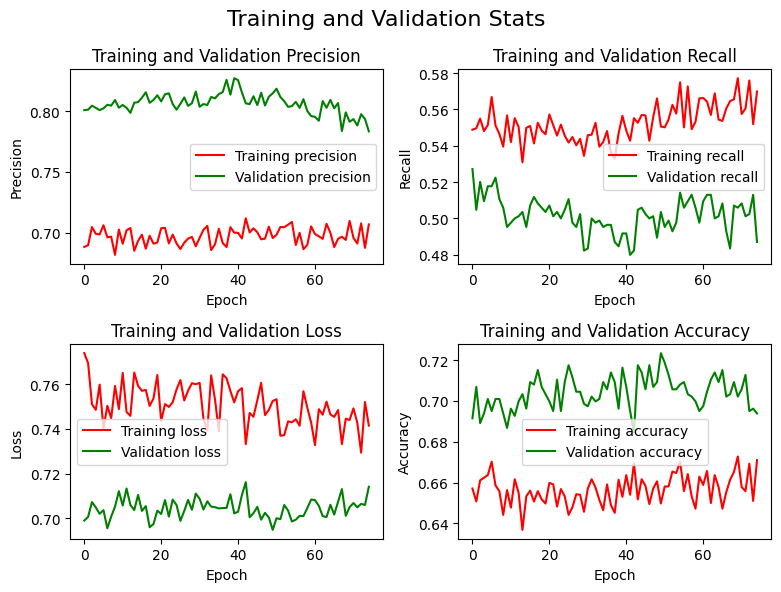

In [66]:
eval = model.evaluate(X_test, Y_test, return_dict = True) # Evaluate the model on the test set

print("Test set evaluation:")
print(f"Precision: {eval['Precision']:.4f}")
print(f"Recall:    {eval['Recall']:.4f}")
print(f"Loss:      {eval['loss']:.4f}")
print(f"Accuracy:  {eval['accuracy']:.4f}")

fig, plots = plt.subplots(2, 2, figsize = (8, 6)) # Create a figure with 2 subplots
fig.suptitle('Training and Validation Stats', fontsize = 16)

# Training and validation loss
plots[0, 0].set_title('Training and Validation Precision')
plots[0, 0].plot(history.history['Precision'],     label = 'Training precision',   color = 'red')
plots[0, 0].plot(history.history['val_Precision'], label = 'Validation precision', color = 'green')
plots[0, 0].set_xlabel('Epoch')
plots[0, 0].set_ylabel('Precision')
plots[0, 0].legend()

# Training and validation loss
plots[0, 1].set_title('Training and Validation Recall')
plots[0, 1].plot(history.history['Recall'],     label = 'Training recall',   color = 'red')
plots[0, 1].plot(history.history['val_Recall'], label = 'Validation recall', color = 'green')
plots[0, 1].set_xlabel('Epoch')
plots[0, 1].set_ylabel('Recall')
plots[0, 1].legend()

# Training and validation loss
plots[1, 0].set_title('Training and Validation Loss')
plots[1, 0].plot(history.history['loss'],     label = 'Training loss',   color = 'red')
plots[1, 0].plot(history.history['val_loss'], label = 'Validation loss', color = 'green')
plots[1, 0].set_xlabel('Epoch')
plots[1, 0].set_ylabel('Loss')
plots[1, 0].legend()

# Training and validation accuracy
plots[1, 1].set_title('Training and Validation Accuracy')
plots[1, 1].plot(history.history['accuracy'],     label = 'Training accuracy',   color = 'red')
plots[1, 1].plot(history.history['val_accuracy'], label = 'Validation accuracy', color = 'green')
plots[1, 1].set_xlabel('Epoch')
plots[1, 1].set_ylabel('Accuracy')
plots[1, 1].legend()

fig.tight_layout() # Adjust layout to prevent overlap
plt.show()         # Show the plots